# Описание проекта

**Описание проекта:** Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей которые готовы совершить покупку в ближайшее время.
Предоставлены данные по истории покупателей. Есть история реакции клиента на преведенные коммуникации. Коммуникация это - промо-предложение, направленное в смс / push сообщении, или электронной почте. По каждому товару проставлена категория, которая помогает определить насколько покупатель “латентен” (предпочтителен) к этой группе товаров.<br>

**Цель** -  создать модель прогнозирования покупки каждым покупателем в ближайшие 90 дней. Это нужно для улучшения работы и повышения эффективности марктетинговых компаний.<br>

**Описание данных:**<br>
* `apparel-purchases` - Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук. В таблице есть списки идентификаторов, к каким категориям относится товар. Часто это вложенные категории (например автотовары-аксессуары-освежители), но также может включать в начале списка маркер распродажи или маркер женщинам/мужчинам. Нумерация категорий сквозная для всех уровней, то есть 44 на второй позиции списка или на третьей – это одна и та же категория. Иногда дерево категорий обновляется, поэтому могут меняться вложенности, например (4, 28, 44, 1594) или (4, 44, 1594). Необходимо обработать такие случаи.
    * client_id - идентификатор клиента
    * quantity - количество единиц товара
    * price - цена товара
    * category_ids - идентификаторы категорий
    * date - дата покупки
    * message_id - идентификатор сообщения из рассылки<br><br>
    
* `apparel-messages` - Рассылки, которые были отправлены клиентам из таблицы покупок.<br>
    * `bulk_campaign_id` - идентификатор рассылки
    * `client_id` - идентификатор клиента
    * `message_id` - идентификатор сообщения
    * `event` - действие с сообщением (отправлено, открыто, покупка…)
    * `channel` - канал рассылки
    * `date` - дата действия
    * `created_at` - дата-время полностью<br><br>
    
* target - Целевой признак
    * `client_id` - идентификатор клиента
    * `target` - клиент совершил покупку в целевом периоде<br><br>
    
* full_campaign_daily_event - Агрегация общей базы рассылок по дням и типам событий
    * `date` - дата
    * `bulk_campaign_id` - идентификатор рассылки
    * `count_event` - общее количество каждого события event
    * `nunique_event` - количество уникальных client_id в каждом событии. В именах колонок найдете все типы событий `event`.<br><br>
* full_campaign_daily_event_channel - Агрегация по дням с учетом событий и каналов рассылки
    * `date` - дата
    * `bulk_campaign_id` - идентификатор рассылки
    * `count_event*_channel` - общее количество каждого события по каналам
    * `nunique_event*_channel` - количество уникальных client_id по событиям и каналам. D именах колонок есть все типы событий event и каналов рассылки `channel`.

# Импорт библиотек

In [1]:
import warnings, os, ast, json, time
warnings.filterwarnings("ignore")
import importlib.metadata as md

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML utils
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, precision_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

# Балансировка
from imblearn.over_sampling import SMOTE

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Корреляции и интерпретация
import phik
from phik.report import plot_correlation_matrix
import shap

sns.set_theme(style="whitegrid", palette="muted")
pd.set_option("display.max_columns", None)

In [2]:
libs = ["pandas","numpy","matplotlib","seaborn","scikit-learn","xgboost","lightgbm","catboost","phik","shap","imbalanced-learn"]
versions = {lib: md.version(lib if lib!="scikit-learn" else "scikit-learn") for lib in libs}
print(json.dumps(versions, indent=2, ensure_ascii=False))

{
  "pandas": "2.3.2",
  "numpy": "1.24.4",
  "matplotlib": "3.10.6",
  "seaborn": "0.13.2",
  "scikit-learn": "1.4.2",
  "xgboost": "2.1.4",
  "lightgbm": "4.6.0",
  "catboost": "1.2.7",
  "phik": "0.12.5",
  "shap": "0.48.0",
  "imbalanced-learn": "0.11.0"
}


In [3]:
#  Константы
RANDOM_STATE = 42
N_JOBS = -1
CV_SPLITS = 3
TEST_SIZE = 0.25
np.random.seed(RANDOM_STATE)

In [4]:
M1, M2 = "apparel-messages.csv", "/datasets/apparel-messages.csv"
P1, P2 = "apparel-purchases.csv", "/datasets/apparel-purchases.csv"
T1, T2 = "apparel-target_binary.csv", "/datasets/apparel-target_binary.csv"
ARTIFACTS_DIR = "artifacts"
os.makedirs(ARTIFACTS_DIR, exist_ok=True)

## Вспомогательные утилиты

In [5]:
def most_freq(s: pd.Series, default="0"):
    m = s.mode()
    return m.iloc[0] if not m.empty else default

def show_info(df: pd.DataFrame, name: str = "DataFrame", n=5):
    print(f"=== {name} ===")
    display(df.head(n))
    print("shape:", df.shape)
    print("nulls:\n", df.isna().sum())
    # безопасный duplicated: исключаем не-хэшируемые колонки (list, dict, np.ndarray)
    safe_cols = []
    for c in df.columns:
        try:
            hash(df[c].iloc[0])
            safe_cols.append(c)
        except Exception:
            pass
    try:
        print("dups:", df.duplicated(subset=safe_cols).sum())
    except Exception as e:
        print("dups: skipped ->", e)
    display(df.describe(include="all"))

def timer(msg=""):
    t0 = time.time()
    def done():
        print(f"[{msg}] {time.time()-t0:.2f}s")
    return done

## Загрузка данных

In [6]:
def load_df(pth1, pth2, parse_dates=None):
    if os.path.exists(pth1):
        return pd.read_csv(pth1, parse_dates=parse_dates)
    if os.path.exists(pth2):
        return pd.read_csv(pth2, parse_dates=parse_dates)
    raise FileNotFoundError(f"Файл не найден: {pth1} или {pth2}")

In [7]:
df_messages = load_df(M1, M2, parse_dates=["date","created_at"])
df_purchases = load_df(P1, P2, parse_dates=["date"])
df_target    = load_df(T1, T2)
show_info(df_messages, "Messages (raw)")
show_info(df_purchases, "Purchases (raw)")
show_info(df_target, "Target (raw)")

=== Messages (raw) ===


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


shape: (12739798, 7)
nulls:
 bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64
dups: 48610


,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
count,1.273980e+07,1.273980e+07,12739798,12739798,12739798,12739798,12739798
unique,NaN,NaN,9061667,11,2,NaN,NaN
top,NaN,NaN,1515915625489095763-6251-6311b13a4cf78,send,mobile_push,NaN,NaN
freq,NaN,NaN,1454,9058196,7512156,NaN,NaN
mean,1.160459e+04,1.515916e+18,NaN,NaN,NaN,2023-06-05 02:46:08.357990400,2023-06-05 13:58:11.168689408
min,5.480000e+02,1.515916e+18,NaN,NaN,NaN,2022-05-19 00:00:00,2022-05-19 00:14:20
25%,8.746000e+03,1.515916e+18,NaN,NaN,NaN,2022-12-19 00:00:00,2022-12-19 12:46:30
50%,1.351600e+04,1.515916e+18,NaN,NaN,NaN,2023-07-20 00:00:00,2023-07-20 17:21:54
75%,1.415800e+04,1.515916e+18,NaN,NaN,NaN,2023-11-21 00:00:00,2023-11-21 18:13:05
max,1.465700e+04,1.515916e+18,NaN,NaN,NaN,2024-02-15 00:00:00,2024-02-15 23:58:40


=== Purchases (raw) ===


,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.0,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.0,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.0,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.0,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


shape: (202208, 6)
nulls:
 client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64
dups: 73020


,client_id,quantity,price,category_ids,date,message_id
count,2.022080e+05,202208.000000,202208.000000,202208,202208,202208
unique,NaN,NaN,NaN,933,NaN,50204
top,NaN,NaN,NaN,"['4', '28', '57', '431']",NaN,1515915625489095763-6251-6311b13a4cf78
freq,NaN,NaN,NaN,8626,NaN,365
mean,1.515916e+18,1.006483,1193.301516,NaN,2023-03-17 02:49:35.739832064,NaN
min,1.515916e+18,1.000000,1.000000,NaN,2022-05-16 00:00:00,NaN
25%,1.515916e+18,1.000000,352.000000,NaN,2022-11-12 00:00:00,NaN
50%,1.515916e+18,1.000000,987.000000,NaN,2023-04-12 00:00:00,NaN
75%,1.515916e+18,1.000000,1699.000000,NaN,2023-07-03 00:00:00,NaN
max,1.515916e+18,30.000000,85499.000000,NaN,2024-02-16 00:00:00,NaN


=== Target (raw) ===


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


shape: (49849, 2)
nulls:
 client_id    0
target       0
dtype: int64
dups: 0


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


## Предобработка и удаление дубликатов

In [8]:
df_messages = df_messages.drop_duplicates().copy()
if "created_at" in df_messages.columns:
    df_messages = df_messages.drop(columns=["created_at"])
df_purchases = df_purchases.drop_duplicates().copy()
df_target    = df_target.drop_duplicates().copy()

In [9]:
clients_m = set(df_messages["client_id"].unique())
clients_p = set(df_purchases["client_id"].unique())
clients_t = set(df_target["client_id"].unique())

print("targets not in purchases:", len(clients_t - clients_p))
print("purchases not in messages:", len(clients_p - clients_m))
print("messages not in purchases:", len(clients_m - clients_p))

msg_in_p = set(df_purchases["message_id"].unique())
msg_in_m = set(df_messages["message_id"].unique())
print("message_id in purchases not in messages:", len(msg_in_p - msg_in_m))
print("message_id in messages not in purchases:", len(msg_in_m - msg_in_p))

targets not in purchases: 0
purchases not in messages: 7867
messages not in purchases: 11347
message_id in purchases not in messages: 394
message_id in messages not in purchases: 9011857


1. **Target ⊆ Purchases**  
   Все клиенты из целевой выборки (`target`) присутствуют в данных о покупках (`purchases`).  
   Это корректно, так как целевой признак основан на факте покупки.  

2. **Purchases ⊄ Messages**  
   Часть клиентов совершала покупки, но по ним отсутствуют записи в таблице сообщений (`messages`).  
   Возможные причины:  
   - неполные данные о коммуникациях;  
   - покупка без взаимодействия с сообщениями (например, прямой визит).  

3. **Messages ≫ Purchases**  
   Объём сообщений значительно превышает количество покупок.  
   Это ожидаемо: большинство сообщений не приводят к покупке, что отражает реальное клиентское поведение.  


-  чистка дублей в df_messages

- Проверяем дубликаты по комбинации колонок:
  - `message_id`
  - `event`
  - `channel`
  - `client_id`

- Удаляем строки, которые повторяются полностью по этим 4 признакам.

- После очистки остаётся только **уникальная запись** для каждой комбинации  
  (`message_id`, `event`, `channel`, `client_id`).

То есть убираем ситуации, когда одно и то же событие одного и того же сообщения
от одного клиента по одному каналу записано несколько раз.

In [10]:
dup_count_before = df_messages.duplicated(
    subset=["message_id","event","channel","client_id"],
    keep=False
).sum()

print(f"Дубликатов перед очисткой: {dup_count_before}")

# Удаляем дубли
df_messages = df_messages.drop_duplicates(
    subset=["message_id","event","channel","client_id"]
).copy()

# Проверяем, что осталось
dup_count_after = df_messages.duplicated(
    subset=["message_id","event","channel","client_id"],
    keep=False
).sum()

print(f"Дубликатов после очистки: {dup_count_after}")
print(f"Осталось строк в df_messages: {len(df_messages):,}")

Дубликатов перед очисткой: 479854
Дубликатов после очистки: 0
Осталось строк в df_messages: 12,401,356


In [11]:
# Ячейка 9 — Проверка диапазонов дат
print("Purchases date min/max:", df_purchases["date"].min(), df_purchases["date"].max())
print("Messages  date min/max:", df_messages["date"].min(),  df_messages["date"].max())

Purchases date min/max: 2022-05-16 00:00:00 2024-02-16 00:00:00
Messages  date min/max: 2022-05-19 00:00:00 2024-02-15 00:00:00


## Обработка категорий товаров в чеках и формирование признаков

In [12]:
df_purchases["category_ids"] = (
    df_purchases["category_ids"]
    .astype(str)
    .str.strip("[] ")
    .str.replace("'", "")  
    .str.split(",") 
)

# считаем длину списков
df_purchases["cat_len"] = df_purchases["category_ids"].apply(len)

print(df_purchases["cat_len"].describe())
print("Максимум категорий в одном чеке:", df_purchases["cat_len"].max())

# примеры "длинных" чеков
print(df_purchases[df_purchases["cat_len"] > 3]["category_ids"].head(10))

count    129188.000000
mean          3.918948
std           0.485672
min           1.000000
25%           4.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: cat_len, dtype: float64
Максимум категорий в одном чеке: 5
0           [4,  28,  57,  431]
1           [4,  28,  57,  431]
2           [4,  28,  57,  431]
3          [4,  28,  244,  432]
4           [4,  28,  49,  413]
5          [2,  18,  258,  441]
6         [2,  18,  341,  1311]
7          [2,  18,  123,  451]
8    [5562,  5631,  5549,  667]
9    [5562,  5630,  5649,  678]
Name: category_ids, dtype: object


In [13]:
def _to_list(x):
    if isinstance(x, list):
        return x
    try:
        return ast.literal_eval(x)
    except Exception:
        return []
df_purchases["category_ids"] = df_purchases["category_ids"].apply(_to_list)
df_purchases[["cat1","cat2","cat3","cat4","cat5"]] = pd.DataFrame(
    df_purchases["category_ids"].apply(lambda x: (x+["0"]*5)[:5]).to_list(),
    index=df_purchases.index
)
# сразу убираем список, чтобы не ломать duplicated/EDA
df_purchases = df_purchases.drop(columns=["category_ids"])

In [14]:
# Просмотр после очистки
show_info(df_messages, "Messages (clean)")
show_info(df_purchases, "Purchases (clean)")
show_info(df_target,    "Target (clean)")

=== Messages (clean) ===


,bulk_campaign_id,client_id,message_id,event,channel,date
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19


shape: (12401356, 6)
nulls:
 bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
dtype: int64
dups: 0


,bulk_campaign_id,client_id,message_id,event,channel,date
count,1.240136e+07,1.240136e+07,12401356,12401356,12401356,12401356
unique,NaN,NaN,9061667,11,2,NaN
top,NaN,NaN,1515915625588077337-6374-63241bb3c8b77,send,mobile_push,NaN
freq,NaN,NaN,6,9055427,7428574,NaN
mean,1.164809e+04,1.515916e+18,NaN,NaN,NaN,2023-06-07 10:10:07.996742400
min,5.480000e+02,1.515916e+18,NaN,NaN,NaN,2022-05-19 00:00:00
25%,8.902000e+03,1.515916e+18,NaN,NaN,NaN,2022-12-21 00:00:00
50%,1.353700e+04,1.515916e+18,NaN,NaN,NaN,2023-07-24 00:00:00
75%,1.416600e+04,1.515916e+18,NaN,NaN,NaN,2023-11-22 00:00:00
max,1.465700e+04,1.515916e+18,NaN,NaN,NaN,2024-02-15 00:00:00


=== Purchases (clean) ===


,client_id,quantity,price,date,message_id,cat_len,cat1,cat2,cat3,cat4,cat5
0,1515915625468169594,1,1999.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,4,28,57,431,0
1,1515915625468169594,1,2499.0,2022-05-16,1515915625468169594-4301-627b661e9736d,4,4,28,57,431,0
2,1515915625471138230,1,6499.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,4,28,57,431,0
3,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,4,28,244,432,0
4,1515915625471138230,1,4999.0,2022-05-16,1515915625471138230-4437-6282242f27843,4,4,28,49,413,0


shape: (129188, 11)
nulls:
 client_id     0
quantity      0
price         0
date          0
message_id    0
cat_len       0
cat1          0
cat2          0
cat3          0
cat4          0
cat5          0
dtype: int64
dups: 0


,client_id,quantity,price,date,message_id,cat_len,cat1,cat2,cat3,cat4,cat5
count,1.291880e+05,129188.000000,129188.000000,129188,129188,129188.000000,129188,129188,129188,129188,129188
unique,NaN,NaN,NaN,NaN,50204,NaN,10,32,292,839,2
top,NaN,NaN,NaN,NaN,1515915625489095763-6251-6311b13a4cf78,NaN,4,28,57,431,0
freq,NaN,NaN,NaN,NaN,222,NaN,73428,53564,6191,6191,128843
mean,1.515916e+18,1.009420,1264.532766,2023-02-26 07:40:09.771805440,NaN,3.918948,NaN,NaN,NaN,NaN,NaN
min,1.515916e+18,1.000000,1.000000,2022-05-16 00:00:00,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
25%,1.515916e+18,1.000000,399.000000,2022-09-09 00:00:00,NaN,4.000000,NaN,NaN,NaN,NaN,NaN
50%,1.515916e+18,1.000000,999.000000,2023-03-22 00:00:00,NaN,4.000000,NaN,NaN,NaN,NaN,NaN
75%,1.515916e+18,1.000000,1750.000000,2023-06-28 00:00:00,NaN,4.000000,NaN,NaN,NaN,NaN,NaN
max,1.515916e+18,30.000000,85499.000000,2024-02-16 00:00:00,NaN,5.000000,NaN,NaN,NaN,NaN,NaN


=== Target (clean) ===


,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


shape: (49849, 2)
nulls:
 client_id    0
target       0
dtype: int64
dups: 0


,client_id,target
count,4.984900e+04,49849.000000
mean,1.515916e+18,0.019278
std,1.487947e+08,0.137503
min,1.515916e+18,0.000000
25%,1.515916e+18,0.000000
50%,1.515916e+18,0.000000
75%,1.515916e+18,0.000000
max,1.515916e+18,1.000000


In [15]:
# на всякий случай убеждаемся, что дата — datetime
df_purchases["date"] = pd.to_datetime(df_purchases["date"])

df_purchases["revenue"] = df_purchases["quantity"] * df_purchases["price"]
max_date = df_purchases["date"].max()

# Флаг на уровне СТРОК (нужен для суммирования в purchases_agg)
df_purchases["count_buy_90"] = (df_purchases["date"] >= max_date - pd.Timedelta(days=90)).astype(int)

# Агрегация по client_id
client_info_df = (
    df_purchases
    .groupby("client_id")
    .agg(
        date_min=("date", "min"),
        date_max=("date", "max"),
        purchase_count=("date", "count"),
        purchase_sum=("revenue", "sum"),
    )
    .reset_index()
)

client_info_df["date_delta"] = (client_info_df["date_max"] - client_info_df["date_min"]).dt.days
client_info_df["days_without_purchases"] = (max_date - client_info_df["date_max"]).dt.days

purchase_days = (
    df_purchases[["client_id", "date"]]
    .drop_duplicates()
    .groupby("client_id")
    .size()
    .reset_index(name="purchase_day_count")
)
client_info_df = client_info_df.merge(purchase_days, on="client_id", how="left")

client_info_df["mean_purchase_period"] = (
    client_info_df["date_delta"] / client_info_df["purchase_day_count"]
).fillna(0).round().astype(int)

# Флаг: была ли покупка за последние 90 дней (на уровне клиента — по последней покупке)
client_info_df["count_buy_90"] = (
    client_info_df["date_max"] >= max_date - pd.Timedelta(days=90)
).astype(int)

display(client_info_df.head())

,client_id,date_min,date_max,purchase_count,purchase_sum,date_delta,days_without_purchases,purchase_day_count,mean_purchase_period,count_buy_90
0,1515915625468060902,2022-05-27,2022-05-27,5,4795.0,0,630,1,0,0
1,1515915625468061003,2023-01-04,2023-01-04,6,14135.0,0,408,1,0,0
2,1515915625468061099,2022-05-17,2022-05-17,1,299.0,0,640,1,0,0
3,1515915625468061100,2024-02-10,2024-02-10,1,1049.0,0,6,1,0,1
4,1515915625468061170,2023-03-26,2023-06-17,8,14102.0,83,244,3,28,0


Признаки по покупкам
- **revenue** — сумма покупки (quantity × price)  
- **count_buy_90** — флаг покупки в последние 90 дней  
- **date_min / date_max** — первая и последняя покупка клиента  
- **purchase_count** — количество покупок  
- **purchase_sum** — сумма всех покупок  
- **date_delta** — период между первой и последней покупкой (в днях)  
- **days_without_purchases** — сколько дней прошло с последней покупки  
- **purchase_day_count** — количество уникальных дней с покупками  
- **mean_purchase_period** — средний интервал между днями покупок

In [16]:
def most_freq(s: pd.Series):
    m = s.mode()
    return m.iloc[0] if not m.empty else np.nan

purchases_agg = df_purchases.groupby("client_id").agg(
    quantity_sum=("quantity","sum"),
    revenue_sum =("revenue","sum"),
    first_date  =("date","min"),
    last_date   =("date","max"),
    purchase_days=("date", lambda s: s.dt.date.nunique()),
    count_buy_90=("count_buy_90","sum"),
    message_id_nunique=("message_id","nunique"),
    cat1=("cat1", most_freq),
    cat2=("cat2", most_freq),
    cat3=("cat3", most_freq),
    cat4=("cat4", most_freq),
    cat5=("cat5", most_freq),
).reset_index()

Агрегации по покупкам
- **quantity_sum** — общее количество купленных товаров  
- **revenue_sum** — суммарная выручка  
- **first_date / last_date** — даты первой и последней покупки  
- **purchase_days** — количество уникальных дней с покупками  
- **count_buy_90** — количество покупок за последние 90 дней  
- **message_id_nunique** — количество уникальных сообщений, связанных с покупками  
- **cat1..cat5** — наиболее частая категория в каждой позиции  


In [17]:
purchases_agg["days_active"] = (purchases_agg["last_date"] - purchases_agg["first_date"]).dt.days
purchases_agg["days_since_last"] = (max_date - purchases_agg["last_date"]).dt.days
purchases_agg["avg_price"] = (
    purchases_agg["revenue_sum"] / purchases_agg["quantity_sum"].replace(0, np.nan)
).fillna(0.0)

Производные признаки по датам
- **days_active** — длительность покупательской активности (от первой до последней покупки)  
- **days_since_last** — сколько дней прошло с последней покупки

Средний период между покупками

In [18]:
purchases_agg["mean_purchase_period"] = (
    purchases_agg["days_active"] / purchases_agg["purchase_days"].replace(0, np.nan)
).fillna(purchases_agg["days_active"]).round().astype(int)

- Частотное кодирование  признаков

In [19]:
def freq_encode(series: pd.Series):
    freq = series.value_counts().to_dict()
    return series.map(freq).fillna(0).astype(int), freq

enc_maps = {}
for col in ["cat1","cat2","cat3","cat4","cat5"]:
    purchases_agg[col+"_freq"], enc_maps[col] = freq_encode(purchases_agg[col])
purchases_agg = purchases_agg.drop(columns=["cat1","cat2","cat3","cat4","cat5"])

In [20]:
show_info(purchases_agg, "purchases_agg")

=== purchases_agg ===


,client_id,quantity_sum,revenue_sum,first_date,last_date,purchase_days,count_buy_90,message_id_nunique,days_active,days_since_last,avg_price,mean_purchase_period,cat1_freq,cat2_freq,cat3_freq,cat4_freq,cat5_freq
0,1515915625468060902,5,4795.0,2022-05-27,2022-05-27,1,0,1,0,630,959.000000,0,30315,23992,127,88,49690
1,1515915625468061003,6,14135.0,2023-01-04,2023-01-04,1,0,1,0,408,2355.833333,0,30315,23992,1152,424,49690
2,1515915625468061099,1,299.0,2022-05-17,2022-05-17,1,0,1,0,640,299.000000,0,30315,23992,1358,270,49690
3,1515915625468061100,1,1049.0,2024-02-10,2024-02-10,1,1,1,0,6,1049.000000,0,30315,2469,452,13,49690
4,1515915625468061170,8,14102.0,2023-03-26,2023-06-17,3,0,3,83,244,1762.750000,28,30315,23992,2446,2160,49690


shape: (49849, 17)
nulls:
 client_id               0
quantity_sum            0
revenue_sum             0
first_date              0
last_date               0
purchase_days           0
count_buy_90            0
message_id_nunique      0
days_active             0
days_since_last         0
avg_price               0
mean_purchase_period    0
cat1_freq               0
cat2_freq               0
cat3_freq               0
cat4_freq               0
cat5_freq               0
dtype: int64
dups: 0


,client_id,quantity_sum,revenue_sum,first_date,last_date,purchase_days,count_buy_90,message_id_nunique,days_active,days_since_last,avg_price,mean_purchase_period,cat1_freq,cat2_freq,cat3_freq,cat4_freq,cat5_freq
count,4.984900e+04,49849.000000,49849.000000,49849,49849,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.00000,49849.000000,49849.000000,49849.000000,49849.000000
mean,1.515916e+18,2.616000,3301.201850,2023-01-28 22:28:08.314710272,2023-02-19 01:38:30.329193984,1.207808,0.269394,1.170174,21.132199,361.931593,1492.021948,8.531565,21533.00995,13309.514594,1096.318943,777.223154,49532.014303
min,1.515916e+18,1.000000,1.000000,2022-05-16 00:00:00,2022-05-16 00:00:00,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,159.000000
25%,1.515916e+18,1.000000,1167.000000,2022-08-03 00:00:00,2022-08-23 00:00:00,1.000000,0.000000,1.000000,0.000000,233.000000,699.000000,0.000000,9210.00000,2068.000000,280.000000,130.000000,49690.000000
50%,1.515916e+18,2.000000,2099.000000,2022-12-26 00:00:00,2023-03-05 00:00:00,1.000000,0.000000,1.000000,0.000000,348.000000,1256.500000,0.000000,30315.00000,7793.000000,721.000000,483.000000,49690.000000
75%,1.515916e+18,3.000000,3998.000000,2023-06-14 00:00:00,2023-06-28 00:00:00,1.000000,0.000000,1.000000,0.000000,542.000000,1999.000000,0.000000,30315.00000,23992.000000,2070.000000,1166.000000,49690.000000
max,1.515916e+18,161.000000,297954.000000,2024-02-16 00:00:00,2024-02-16 00:00:00,41.000000,44.000000,27.000000,636.000000,641.000000,53499.000000,310.000000,30315.00000,23992.000000,2561.000000,2892.000000,49690.000000
std,1.487947e+08,2.946677,4426.024319,NaN,NaN,0.665728,1.152782,0.576680,76.842637,185.301691,1388.831573,31.290902,11050.65803,10508.300520,908.963152,826.094668,2792.917211


## Анализ клиентской активности

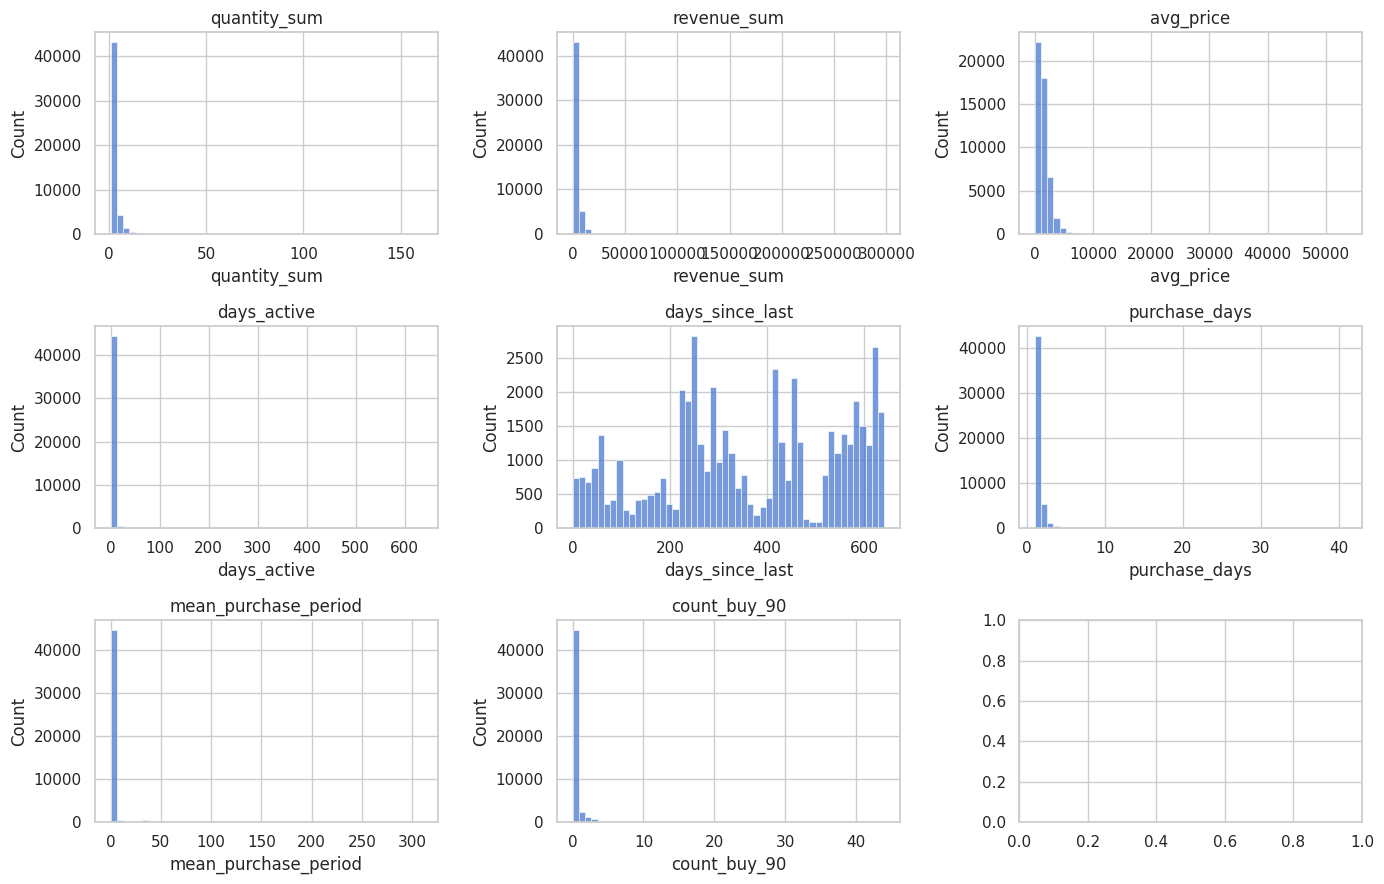

In [21]:
num_cols_quick = ["quantity_sum","revenue_sum","avg_price","days_active","days_since_last","purchase_days","mean_purchase_period","count_buy_90"]
fig, axes = plt.subplots(nrows=len(num_cols_quick)//3+1, ncols=3, figsize=(14, 3*((len(num_cols_quick)//3)+1)))
axes = axes.ravel()
for ax, col in zip(axes, num_cols_quick):
    if col in purchases_agg.columns:
        sns.histplot(purchases_agg[col], bins=50, ax=ax)
        ax.set_title(col)
plt.tight_layout()
plt.show()

In [22]:
assert purchases_agg["client_id"].is_unique, "client_id не уникален в purchases_agg"

In [23]:
purchases_agg.to_csv(os.path.join(ARTIFACTS_DIR, "purchases_agg.csv"), index=False)

In [24]:
display(purchases_agg[["client_id","revenue_sum","quantity_sum"]].sort_values("revenue_sum", ascending=False).head(10))

,client_id,revenue_sum,quantity_sum
24468,1515915625553309277,297954.0,10
41838,1515915625776653984,172763.0,23
48619,1515915625983356708,159687.0,16
44817,1515915625853312319,145809.0,161
47310,1515915625959777467,145497.0,3
18479,1515915625500232103,122772.0,75
46613,1515915625932678769,101937.0,6
10950,1515915625489401199,90410.0,40
4357,1515915625475058209,84283.0,17
45067,1515915625860624470,83972.0,25


In [25]:
# Агрегации messages
messages_agg = df_messages.groupby("client_id").agg(
    bulk_campaign_id_nunique=("bulk_campaign_id","nunique"),
    message_id_nunique_m=("message_id","nunique"),
    first_date_m=("date","min"),
    last_date_m=("date","max"),
    count_date_m=("date","count")
).reset_index()
show_info(messages_agg, "messages_agg")

=== messages_agg ===


,client_id,bulk_campaign_id_nunique,message_id_nunique_m,first_date_m,last_date_m,count_date_m
0,1515915625468060902,127,127,2022-05-19,2024-01-19,167
1,1515915625468061003,154,154,2022-05-20,2024-02-13,164
2,1515915625468061099,215,215,2022-05-19,2024-02-13,274
3,1515915625468061100,265,268,2022-05-19,2024-02-15,424
4,1515915625468061170,240,243,2022-05-25,2024-02-15,288


shape: (53329, 6)
nulls:
 client_id                   0
bulk_campaign_id_nunique    0
message_id_nunique_m        0
first_date_m                0
last_date_m                 0
count_date_m                0
dtype: int64
dups: 0


,client_id,bulk_campaign_id_nunique,message_id_nunique_m,first_date_m,last_date_m,count_date_m
count,5.332900e+04,53329.000000,53329.000000,53329,53329,53329.000000
mean,1.515916e+18,168.064130,169.920062,2022-08-29 02:10:52.778038272,2023-12-11 15:43:07.957771776,232.544319
min,1.515916e+18,1.000000,1.000000,2022-05-19 00:00:00,2022-05-19 00:00:00,1.000000
25%,1.515916e+18,87.000000,88.000000,2022-05-20 00:00:00,2024-02-13 00:00:00,112.000000
50%,1.515916e+18,159.000000,160.000000,2022-05-25 00:00:00,2024-02-14 00:00:00,209.000000
75%,1.515916e+18,247.000000,251.000000,2022-10-28 00:00:00,2024-02-15 00:00:00,330.000000
max,1.515916e+18,2465.000000,2473.000000,2024-02-15 00:00:00,2024-02-15 00:00:00,2842.000000
std,1.585540e+08,112.686263,113.889918,NaN,NaN,167.030304


In [26]:
# One-hot событий и каналов + суммирование по client_id
d_events = pd.get_dummies(df_messages[["client_id","event"]], columns=["event"], drop_first=False)
d_channels = pd.get_dummies(df_messages[["client_id","channel"]], columns=["channel"], drop_first=False)

grouped_events = d_events.groupby("client_id").sum().reset_index()
grouped_channels = d_channels.groupby("client_id").sum().reset_index()

events_channels = grouped_events.merge(grouped_channels, on="client_id", how="outer").fillna(0)

In [27]:
# Признак негативных доставок (hard/soft bounce + spam)
neg_cols = [c for c in events_channels.columns if any(x in c for x in ["event_hard_bounce","event_soft_bounce","event_hbq_spam","event_spam"])]
events_channels["negative_delivery_message"] = events_channels[neg_cols].sum(axis=1) if len(neg_cols)>0 else 0

In [28]:
#  Объединение messages_agg + events_channels
messages_full = messages_agg.merge(events_channels, on="client_id", how="left").fillna(0)
assert messages_full["client_id"].is_unique, "client_id не уникален в messages_full"
show_info(messages_full, "messages_full")

=== messages_full ===


,client_id,bulk_campaign_id_nunique,message_id_nunique_m,first_date_m,last_date_m,count_date_m,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,negative_delivery_message
0,1515915625468060902,127,127,2022-05-19,2024-01-19,167,6,0,0,0,0,33,1,126,0,0,1,167,0,0
1,1515915625468061003,154,154,2022-05-20,2024-02-13,164,4,0,0,0,0,5,1,154,0,0,0,164,0,0
2,1515915625468061099,215,215,2022-05-19,2024-02-13,274,8,0,0,2,0,49,0,215,0,0,0,181,93,2
3,1515915625468061100,265,268,2022-05-19,2024-02-15,424,1,0,0,1,0,153,1,267,1,0,0,0,424,2
4,1515915625468061170,240,243,2022-05-25,2024-02-15,288,12,0,0,0,0,30,3,243,0,0,0,197,91,0


shape: (53329, 20)
nulls:
 client_id                    0
bulk_campaign_id_nunique     0
message_id_nunique_m         0
first_date_m                 0
last_date_m                  0
count_date_m                 0
event_click                  0
event_close                  0
event_complain               0
event_hard_bounce            0
event_hbq_spam               0
event_open                   0
event_purchase               0
event_send                   0
event_soft_bounce            0
event_subscribe              0
event_unsubscribe            0
channel_email                0
channel_mobile_push          0
negative_delivery_message    0
dtype: int64
dups: 0


,client_id,bulk_campaign_id_nunique,message_id_nunique_m,first_date_m,last_date_m,count_date_m,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,negative_delivery_message
count,5.332900e+04,53329.000000,53329.000000,53329,53329,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000,53329.000000
mean,1.515916e+18,168.064130,169.920062,2022-08-29 02:10:52.778038272,2023-12-11 15:43:07.957771776,232.544319,6.564121,0.000019,0.009132,0.369461,0.015433,54.606162,0.931407,169.803053,0.194922,0.001538,0.049073,93.247239,139.297080,0.579816
min,1.515916e+18,1.000000,1.000000,2022-05-19 00:00:00,2022-05-19 00:00:00,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.515916e+18,87.000000,88.000000,2022-05-20 00:00:00,2024-02-13 00:00:00,112.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.515916e+18,159.000000,160.000000,2022-05-25 00:00:00,2024-02-14 00:00:00,209.000000,4.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000,160.000000,0.000000,0.000000,0.000000,83.000000,107.000000,0.000000
75%,1.515916e+18,247.000000,251.000000,2022-10-28 00:00:00,2024-02-15 00:00:00,330.000000,8.000000,0.000000,0.000000,0.000000,0.000000,88.000000,1.000000,250.000000,0.000000,0.000000,0.000000,167.000000,237.000000,1.000000
max,1.515916e+18,2465.000000,2473.000000,2024-02-15 00:00:00,2024-02-15 00:00:00,2842.000000,236.000000,1.000000,56.000000,30.000000,2.000000,1234.000000,32.000000,2473.000000,137.000000,3.000000,7.000000,627.000000,2274.000000,138.000000
std,1.585540e+08,112.686263,113.889918,NaN,NaN,167.030304,8.927559,0.004330,0.337227,0.926405,0.125826,71.141387,0.716918,113.834248,2.814979,0.043276,0.257449,87.737855,147.993857,2.971349


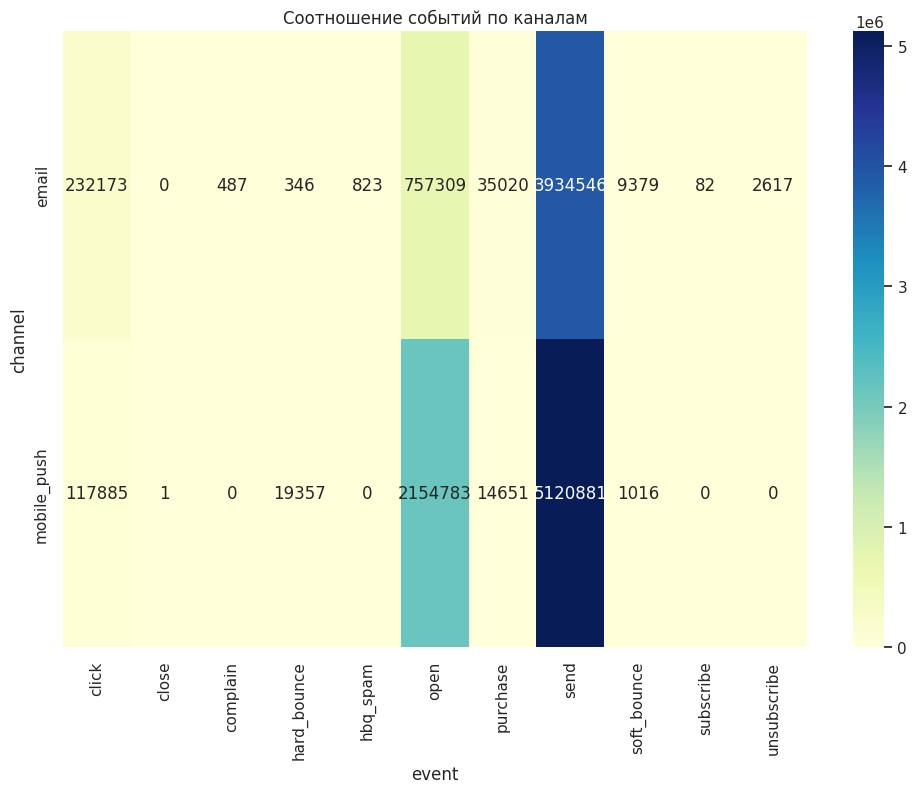

In [29]:
#  Heatmap событий/каналов
heatmap_data = df_messages.pivot_table(index="channel", columns="event", values="message_id", aggfunc="count", fill_value=0)
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Соотношение событий по каналам")
plt.show()

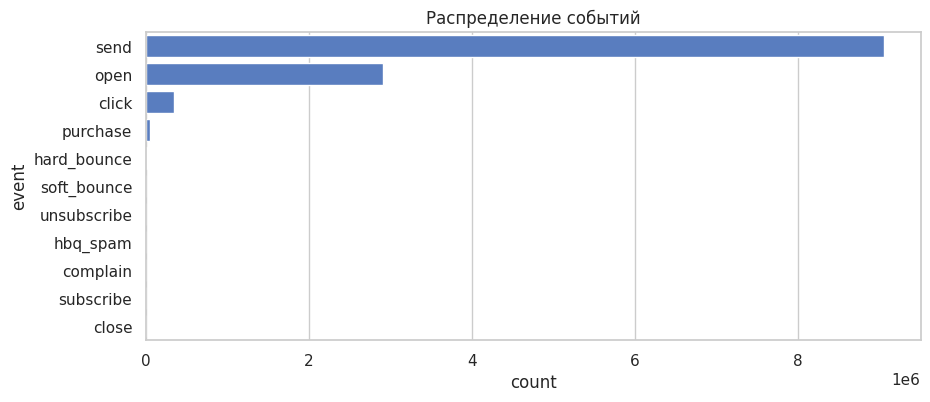

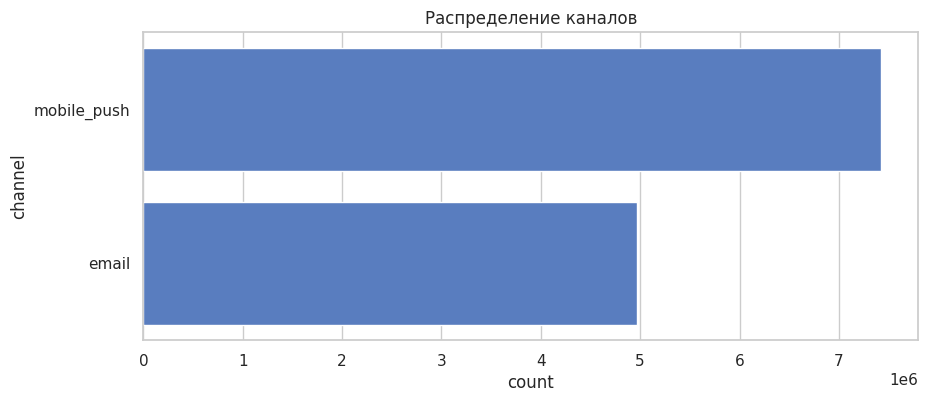

In [30]:
# Распределения event / channel
plt.figure(figsize=(10,4))
sns.countplot(y="event", data=df_messages, order=df_messages["event"].value_counts().index)
plt.title("Распределение событий")
plt.show()

plt.figure(figsize=(10,4))
sns.countplot(y="channel", data=df_messages, order=df_messages["channel"].value_counts().index)
plt.title("Распределение каналов")
plt.show()

# Вывод по распределению событий
- Подавляющее большинство событий — **send** (отправка сообщений).  
- Значительная часть сообщений была **open** (открыта), но гораздо меньше, чем отправлено.  
- События **click** встречаются редко → низкая кликабельность сообщений.  
- Событие **purchase** (покупка) встречается крайне редко → очень маленькая конверсия из коммуникаций в покупки.  
- Негативные события (**hard_bounce, soft_bounce, spam, unsubscribe**) встречаются в единичных случаях → рассылки в целом доставляются.

- Вывод по распределению каналов
- Основной канал коммуникаций — **mobile_push** (~7.3 млн сообщений).  
- Канал **email** используется реже (~5 млн сообщений).  
- Это говорит о том, что мобильные пуш-уведомления являются основным каналом взаимодействия с клиентами, однако эффективность каналов (связь с покупками) нужно дополнительно проверить.

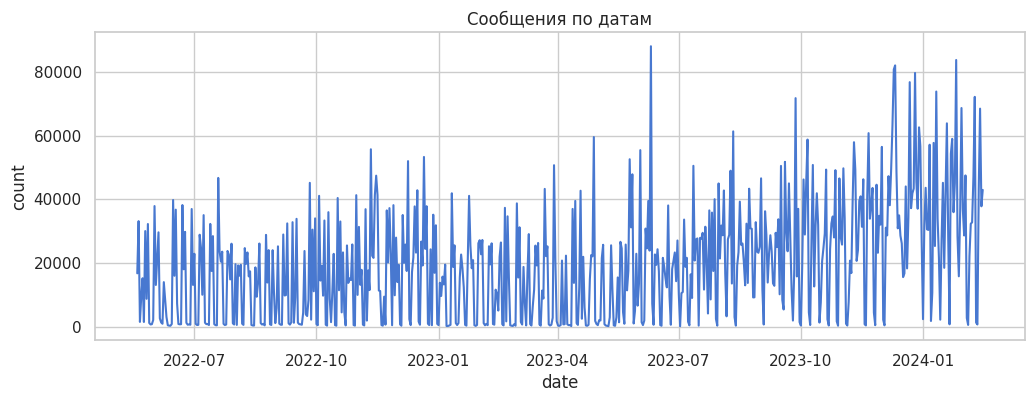

In [31]:
#  Серия сообщений по датам
daily_msgs = df_messages.groupby(df_messages["date"].dt.date).size()
plt.figure(figsize=(12,4))
daily_msgs.plot()
plt.title("Сообщения по датам")
plt.ylabel("count")
plt.show()

In [32]:
#  Проверка target
assert df_target["client_id"].is_unique, "client_id не уникален в target"
df_target["target"] = df_target["target"].astype(int)

In [33]:
# Проверка распределения таргета
print(df_target["target"].value_counts(dropna=False))
print(df_target["target"].value_counts(normalize=True).round(3))

target
0    48888
1      961
Name: count, dtype: int64
target
0    0.981
1    0.019
Name: proportion, dtype: float64


In [34]:
# Merge purchases + messages + target
df = purchases_agg.merge(messages_full, on="client_id", how="left")
df = df.merge(df_target, on="client_id", how="inner")  # берем только клиентов с таргетом
df = df.fillna(0)

# убираем датовые поля (агрегаты оставили)
for c in ["first_date","last_date","first_date_m","last_date_m"]:
    if c in df.columns:
        df = df.drop(columns=[c])

show_info(df, "FINAL DF")

=== FINAL DF ===


,client_id,quantity_sum,revenue_sum,purchase_days,count_buy_90,message_id_nunique,days_active,days_since_last,avg_price,mean_purchase_period,cat1_freq,cat2_freq,cat3_freq,cat4_freq,cat5_freq,bulk_campaign_id_nunique,message_id_nunique_m,count_date_m,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,negative_delivery_message,target
0,1515915625468060902,5,4795.0,1,0,1,0,630,959.000000,0,30315,23992,127,88,49690,127.0,127.0,167.0,6.0,0.0,0.0,0.0,0.0,33.0,1.0,126.0,0.0,0.0,1.0,167.0,0.0,0.0,0
1,1515915625468061003,6,14135.0,1,0,1,0,408,2355.833333,0,30315,23992,1152,424,49690,154.0,154.0,164.0,4.0,0.0,0.0,0.0,0.0,5.0,1.0,154.0,0.0,0.0,0.0,164.0,0.0,0.0,1
2,1515915625468061099,1,299.0,1,0,1,0,640,299.000000,0,30315,23992,1358,270,49690,215.0,215.0,274.0,8.0,0.0,0.0,2.0,0.0,49.0,0.0,215.0,0.0,0.0,0.0,181.0,93.0,2.0,0
3,1515915625468061100,1,1049.0,1,1,1,0,6,1049.000000,0,30315,2469,452,13,49690,265.0,268.0,424.0,1.0,0.0,0.0,1.0,0.0,153.0,1.0,267.0,1.0,0.0,0.0,0.0,424.0,2.0,0
4,1515915625468061170,8,14102.0,3,0,3,83,244,1762.750000,28,30315,23992,2446,2160,49690,240.0,243.0,288.0,12.0,0.0,0.0,0.0,0.0,30.0,3.0,243.0,0.0,0.0,0.0,197.0,91.0,0.0,0


shape: (49849, 33)
nulls:
 client_id                    0
quantity_sum                 0
revenue_sum                  0
purchase_days                0
count_buy_90                 0
message_id_nunique           0
days_active                  0
days_since_last              0
avg_price                    0
mean_purchase_period         0
cat1_freq                    0
cat2_freq                    0
cat3_freq                    0
cat4_freq                    0
cat5_freq                    0
bulk_campaign_id_nunique     0
message_id_nunique_m         0
count_date_m                 0
event_click                  0
event_close                  0
event_complain               0
event_hard_bounce            0
event_hbq_spam               0
event_open                   0
event_purchase               0
event_send                   0
event_soft_bounce            0
event_subscribe              0
event_unsubscribe            0
channel_email                0
channel_mobile_push          0
negative_del

,client_id,quantity_sum,revenue_sum,purchase_days,count_buy_90,message_id_nunique,days_active,days_since_last,avg_price,mean_purchase_period,cat1_freq,cat2_freq,cat3_freq,cat4_freq,cat5_freq,bulk_campaign_id_nunique,message_id_nunique_m,count_date_m,event_click,event_close,event_complain,event_hard_bounce,event_hbq_spam,event_open,event_purchase,event_send,event_soft_bounce,event_subscribe,event_unsubscribe,channel_email,channel_mobile_push,negative_delivery_message,target
count,4.984900e+04,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.00000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000,49849.000000
mean,1.515916e+18,2.616000,3301.201850,1.207808,0.269394,1.170174,21.132199,361.931593,1492.021948,8.531565,21533.00995,13309.514594,1096.318943,777.223154,49532.014303,156.885534,158.521214,213.711509,6.509017,0.000020,0.009128,0.327248,0.015246,47.325142,0.892556,158.407551,0.175731,0.001464,0.048406,92.239243,121.472266,0.518225,0.019278
std,1.487947e+08,2.946677,4426.024319,0.665728,1.152782,0.576680,76.842637,185.301691,1388.831573,31.290902,11050.65803,10508.300520,908.963152,826.094668,2792.917211,116.782900,118.051842,169.987784,9.112162,0.004479,0.346500,0.867883,0.125123,67.434027,0.736791,117.991704,2.631414,0.041268,0.256992,88.845101,142.438652,2.778406,0.137503
min,1.515916e+18,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,159.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.515916e+18,1.000000,1167.000000,1.000000,0.000000,1.000000,0.000000,233.000000,699.000000,0.000000,9210.00000,2068.000000,280.000000,130.000000,49690.000000,58.000000,59.000000,77.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,59.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.515916e+18,2.000000,2099.000000,1.000000,0.000000,1.000000,0.000000,348.000000,1256.500000,0.000000,30315.00000,7793.000000,721.000000,483.000000,49690.000000,150.000000,151.000000,194.000000,4.000000,0.000000,0.000000,0.000000,0.000000,14.000000,1.000000,151.000000,0.000000,0.000000,0.000000,80.000000,71.000000,0.000000,0.000000
75%,1.515916e+18,3.000000,3998.000000,1.000000,0.000000,1.000000,0.000000,542.000000,1999.000000,0.000000,30315.00000,23992.000000,2070.000000,1166.000000,49690.000000,240.000000,243.000000,314.000000,9.000000,0.000000,0.000000,0.000000,0.000000,72.000000,1.000000,243.000000,0.000000,0.000000,0.000000,167.000000,219.000000,0.000000,0.000000
max,1.515916e+18,161.000000,297954.000000,41.000000,44.000000,27.000000,636.000000,641.000000,53499.000000,310.000000,30315.00000,23992.000000,2561.000000,2892.000000,49690.000000,2465.000000,2473.000000,2842.000000,236.000000,1.000000,56.000000,30.000000,2.000000,1234.000000,32.000000,2473.000000,129.000000,3.000000,7.000000,627.000000,2274.000000,130.000000,1.000000


In [35]:
# Список признаков
feature_cols = [c for c in df.columns if c not in ["client_id","target"]]
len(feature_cols), feature_cols[:12]

(31,
 ['quantity_sum',
  'revenue_sum',
  'purchase_days',
  'count_buy_90',
  'message_id_nunique',
  'days_active',
  'days_since_last',
  'avg_price',
  'mean_purchase_period',
  'cat1_freq',
  'cat2_freq',
  'cat3_freq'])

## Phik-корреляция между признаками и удаление сильно коррелирующих

Признаки с корреляцией > 0.95
purchase_days ↔ message_id_nunique: 0.975 → удаляем purchase_days
bulk_campaign_id_nunique ↔ message_id_nunique_m: 1.000 → удаляем bulk_campaign_id_nunique
bulk_campaign_id_nunique ↔ count_date_m: 0.965 → удаляем bulk_campaign_id_nunique
bulk_campaign_id_nunique ↔ event_send: 1.000 → удаляем bulk_campaign_id_nunique
bulk_campaign_id_nunique ↔ channel_mobile_push: 0.959 → удаляем bulk_campaign_id_nunique
message_id_nunique_m ↔ count_date_m: 0.966 → удаляем message_id_nunique_m
message_id_nunique_m ↔ event_send: 1.000 → удаляем message_id_nunique_m
message_id_nunique_m ↔ channel_mobile_push: 0.959 → удаляем message_id_nunique_m
count_date_m ↔ event_send: 0.966 → удаляем event_send
count_date_m ↔ channel_mobile_push: 0.969 → удаляем count_date_m
event_send ↔ channel_mobile_push: 0.959 → удаляем event_send
event_soft_bounce ↔ negative_delivery_message: 0.999 → удаляем negative_delivery_message

Будут удалены: {'purchase_days', 'count_date_m', 'message_id_nuniq

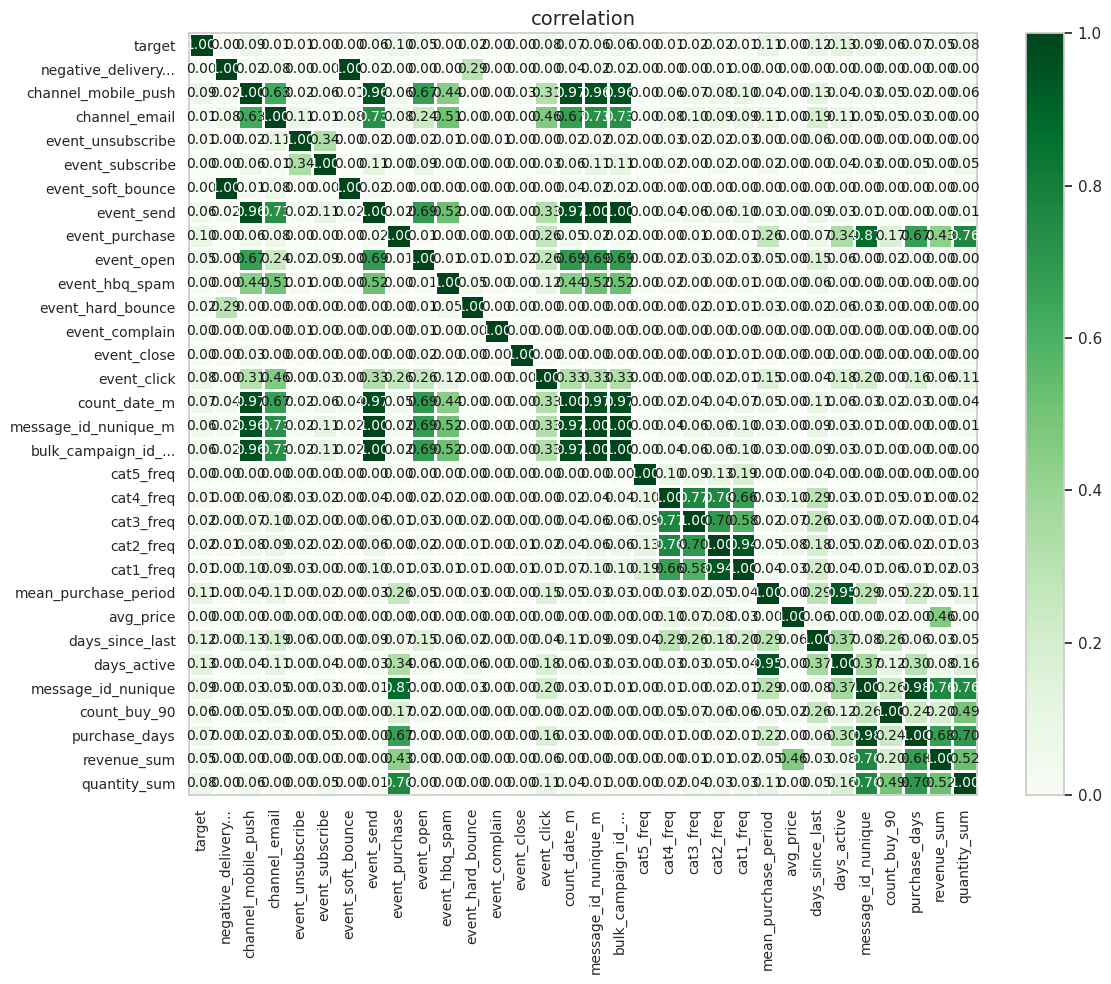

In [36]:
# матрица phik
interval_cols = [c for c in feature_cols if np.issubdtype(df[c].dtype, np.number)]
phik_matrix = df.drop(columns=["client_id"]).phik_matrix(interval_cols=interval_cols)

# визуализация
plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    vmin=0, vmax=1,
    color_map="Greens",
    figsize=(12, 10)
)

# корреляция каждого признака с target
target_corr = phik_matrix["target"].drop("target")

# поиск пар с сильной корреляцией
threshold = 0.95
high_corr = []
for i, col1 in enumerate(phik_matrix.columns):
    for j, col2 in enumerate(phik_matrix.columns):
        if i < j and col1 != "target" and col2 != "target":
            if phik_matrix.iloc[i, j] > threshold:
                high_corr.append((col1, col2, phik_matrix.iloc[i, j]))

print("Признаки с корреляцией >", threshold)
to_drop = set()
for col1, col2, corr in high_corr:
    # выбираем менее связанный с target
    corr1 = target_corr.get(col1, 0)
    corr2 = target_corr.get(col2, 0)
    drop_col = col1 if corr1 < corr2 else col2
    to_drop.add(drop_col)
    print(f"{col1} ↔ {col2}: {corr:.3f} → удаляем {drop_col}")

print("\nБудут удалены:", to_drop)

# удаляем
df = df.drop(columns=to_drop)
feature_cols = [c for c in df.columns if c not in ["client_id", "target"]]

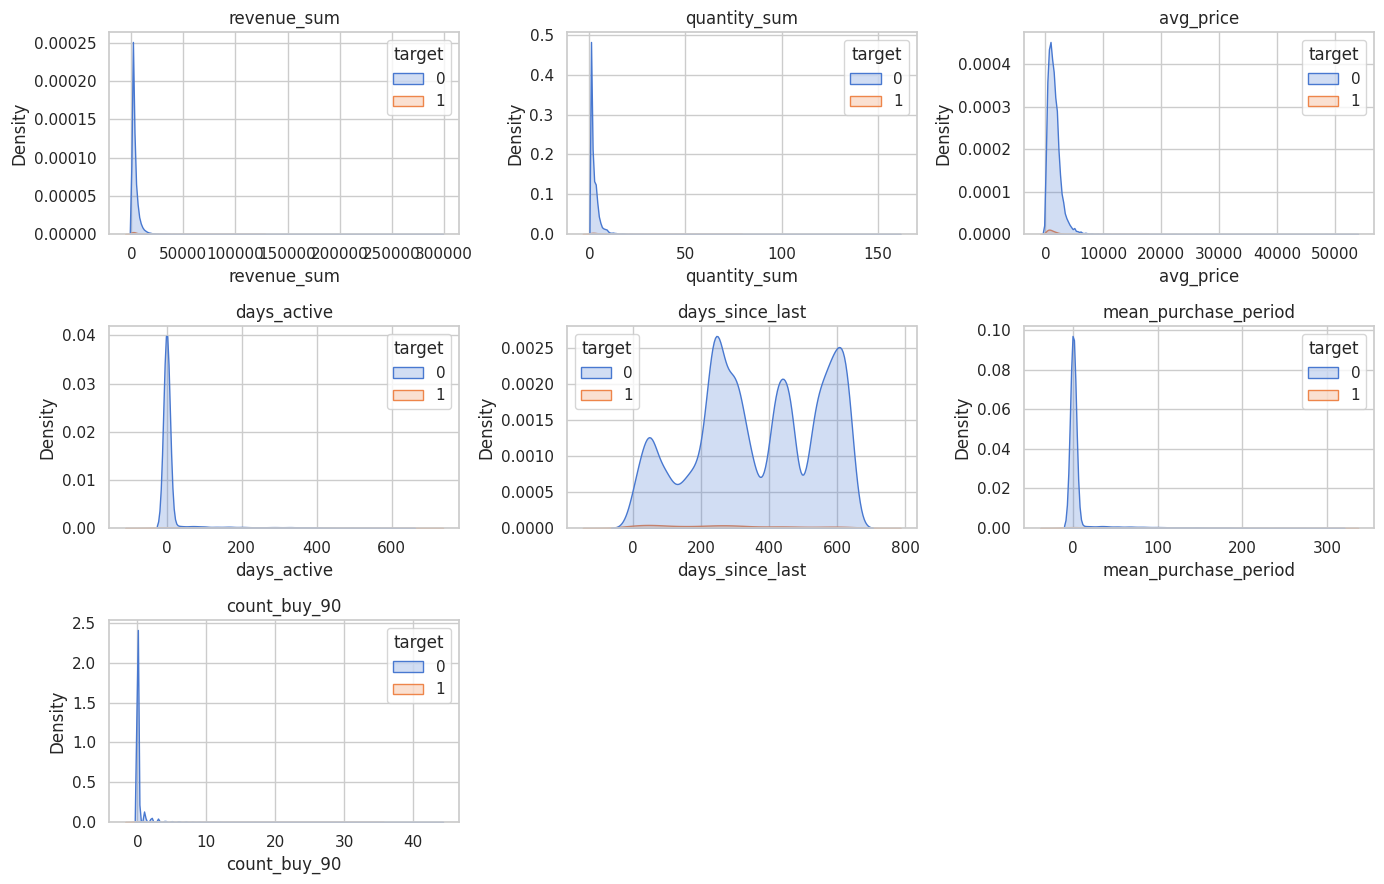

In [37]:
# Визуализации распределений ключевых числовых фич vs target
key_numeric = [
    "revenue_sum","quantity_sum","avg_price","days_active","days_since_last",
    "purchase_days","mean_purchase_period","count_buy_90",
    "bulk_campaign_id_nunique","message_id_nunique_m","count_date_m",
    "negative_delivery_message"
]
key_numeric = [c for c in key_numeric if c in df.columns]

fig, axes = plt.subplots(
    nrows=len(key_numeric)//3+1,
    ncols=3,
    figsize=(14, 3*((len(key_numeric)//3)+1))
)
axes = axes.ravel()


for ax, col in zip(axes, key_numeric):
    sns.kdeplot(data=df, x=col, hue="target", fill=True, ax=ax)
    ax.set_title(col)


for ax in axes[len(key_numeric):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()

Вывод по распределениям признаков vs target

- Временные и частотные признаки (`days_since_last`, `mean_purchase_period`, `count_buy_90`) действительно полезнее, чем чисто финансовые.  
- Финансовые метрики сами по себе классы почти не разделяют, но в комбинации с другими (например, через нелинейные модели) могут дать прибавку.

In [38]:
print("Количество признаков:", len(feature_cols))
print("Список признаков:")
print(feature_cols)

Количество признаков: 25
Список признаков:
['quantity_sum', 'revenue_sum', 'count_buy_90', 'message_id_nunique', 'days_active', 'days_since_last', 'avg_price', 'mean_purchase_period', 'cat1_freq', 'cat2_freq', 'cat3_freq', 'cat4_freq', 'cat5_freq', 'event_click', 'event_close', 'event_complain', 'event_hard_bounce', 'event_hbq_spam', 'event_open', 'event_purchase', 'event_soft_bounce', 'event_subscribe', 'event_unsubscribe', 'channel_email', 'channel_mobile_push']


## Обучение модлей

In [39]:
# Train/Test Split
X = df[feature_cols].copy()
y = df["target"].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()

((37386, 25), (12463, 25), 0.019285293960305996, 0.019257000722137527)

- SMOTE только на тренировчной в противном случае будет утечка данных.

In [40]:
smote = SMOTE(
    sampling_strategy=0.7,
    random_state=RANDOM_STATE
)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("After SMOTE:", X_train_sm.shape, np.bincount(y_train_sm))

After SMOTE: (62330, 25) [36665 25665]


In [41]:
logreg_preprocessor = ColumnTransformer([
    ("num", StandardScaler(), feature_cols)
], remainder="passthrough")

no_preprocessor = "passthrough"

Признаки, создаваемые из `category_ids`

In [42]:
#  Базовые модели
base_models = {
    "LogReg": LogisticRegression(max_iter=1000, solver="liblinear", random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(),
    "GBC": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=RANDOM_STATE, eval_metric="AUC"),
    "LGBM": LGBMClassifier(random_state=RANDOM_STATE, nthread=N_JOBS),
    "XGB": XGBClassifier(random_state=RANDOM_STATE, nthread=N_JOBS, tree_method="hist")}

In [43]:
param_spaces = {
    "LogReg": {
        "model__penalty": ["l2"],
        "model__C": [0.1, 1, 10],
        "model__fit_intercept": [True],
        "model__solver": ["liblinear"],
        "model__class_weight": [None, "balanced"]
    },
    "DecisionTree": {
        "model__max_depth": [3, 5, 7],           
        "model__min_samples_split": [2, 5], 
        "model__min_samples_leaf": [1, 3],
        "model__criterion": ["gini"],
        "model__class_weight": [None, "balanced"]
    },
    "KNN": {
        "model__n_neighbors": [3, 5], 
        "model__weights": ["uniform", "distance"],
        "model__p": [1, 2]
    },
    "GBC": {
        "model__n_estimators": [20, 50],   
        "model__learning_rate": [0.05, 0.1],
        "model__max_depth": [2, 3],
        "model__subsample": [0.8, 1.0]
    },
    "CatBoost": {
        "model__iterations": [20, 50], 
        "model__depth": [4, 6],    
        "model__learning_rate": [0.05, 0.1],
        "model__l2_leaf_reg": [3, 4],  
        "model__scale_pos_weight": [1, 5, 10]
    },
    "LGBM": {
        "model__n_estimators": [20, 50], 
        "model__max_depth": [4, 6],  
        "model__num_leaves": [20, 31],    
        "model__learning_rate": [0.05, 0.1],
        "model__subsample": [0.8],
        "model__colsample_bytree": [0.8], 
        "model__verbose": [-1],
        "model__scale_pos_weight": [1, 5, 10]
    },  
    "XGB": {
        "model__n_estimators": [20, 50],
        "model__max_depth": [4, 6],           
        "model__learning_rate": [0.05, 0.1],
        "model__tree_method": ["hist"],
        "model__verbosity": [0],
        "model__scale_pos_weight": [1, 5, 10]
    },
}

In [44]:
# Конфигурация CV
cv = StratifiedKFold(n_splits=CV_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [45]:
search_results = {}
best_pipes = {}

for name, model in base_models.items():
    print(f"\n=== {name} ===")
    
    # Выбираем препроцессор в зависимости от модели
    if name == "LogReg":
        preproc = logreg_preprocessor
    else:
        preproc = no_preprocessor

    pipe = Pipeline([
        ("preprocessor", preproc),
        ("model", model)
    ])
    
    params = param_spaces[name]
    n_iter = 15 if name in ["LogReg", "DecisionTree", "KNN"] else 25 if name in ["GBC"] else 50

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=params,
        n_iter=n_iter,
        scoring="roc_auc",
        cv=cv,
        random_state=RANDOM_STATE,
        verbose=2,
        n_jobs=N_JOBS
    )

    search.fit(X_train_sm, y_train_sm)
    search_results[name] = {
        "best_score": search.best_score_,
        "best_params": search.best_params_
    }
    best_pipes[name] = search.best_estimator_
    print("Best CV ROC_AUC:", round(search.best_score_, 5))
    print("Best params:", search.best_params_)


=== LogReg ===
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best CV ROC_AUC: 0.76611
Best params: {'model__solver': 'liblinear', 'model__penalty': 'l2', 'model__fit_intercept': True, 'model__class_weight': 'balanced', 'model__C': 10}

=== DecisionTree ===
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Best CV ROC_AUC: 0.94633
Best params: {'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_depth': 7, 'model__criterion': 'gini', 'model__class_weight': None}

=== KNN ===
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best CV ROC_AUC: 0.98424
Best params: {'model__weights': 'distance', 'model__p': 1, 'model__n_neighbors': 5}

=== GBC ===
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best CV ROC_AUC: 0.96209
Best params: {'model__subsample': 1.0, 'model__n_estimators': 50, 'model__max_depth': 3, 'model__learning_rate': 0.1}

=== CatBoost ===
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best CV 

In [46]:
# Сводка метрик на тесте
rows = []
for name, pipe in best_pipes.items():
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    rows.append({
        "model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "ROC_AUC": roc_auc_score(y_test, y_proba)
    })
metrics_df = pd.DataFrame(rows).sort_values("ROC_AUC", ascending=False)
display(metrics_df)
metrics_df.to_csv(os.path.join(ARTIFACTS_DIR, "metrics_test.csv"), index=False)

,model,Accuracy,F1,Recall,Precision,ROC_AUC
0,LogReg,0.729921,0.081332,0.620833,0.043516,0.730258
4,CatBoost,0.970713,0.094293,0.079167,0.116564,0.724871
3,GBC,0.933162,0.099459,0.191667,0.067153,0.720287
5,LGBM,0.961245,0.086957,0.095833,0.079585,0.713241
6,XGB,0.733451,0.067901,0.504167,0.036402,0.687252
1,DecisionTree,0.962609,0.075397,0.079167,0.071970,0.668478
2,KNN,0.904116,0.052339,0.137500,0.032321,0.558370


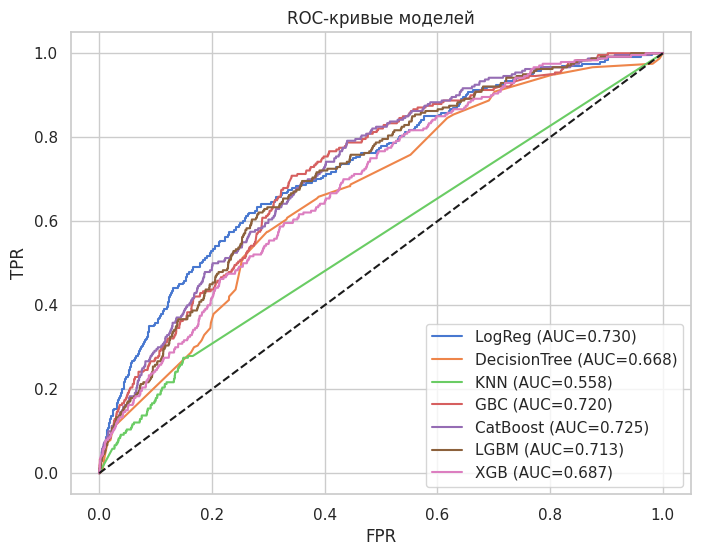

In [47]:
# ROC-кривые для всех моделей
plt.figure(figsize=(8,6))
for name, pipe in best_pipes.items():
    y_proba = pipe.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("ROC-кривые моделей")
plt.legend()
plt.show()

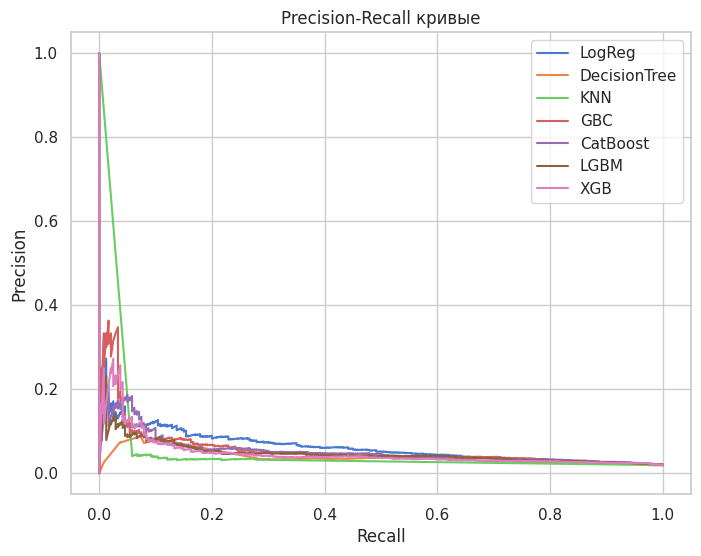

In [48]:
#  PR-кривые (важно при дисбалансе)
plt.figure(figsize=(8,6))
for name, pipe in best_pipes.items():
    y_proba = pipe.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.plot(recall, precision, label=name)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall кривые")
plt.legend()
plt.show()

In [49]:
# Выбор лучшей модели и подбор порога по F1 на тесте
best_name = metrics_df.iloc[0]["model"]
best_pipe = best_pipes[best_name]
y_proba = best_pipe.predict_proba(X_test)[:,1]
prec, rec, thr = precision_recall_curve(y_test, y_proba)
f1_vals = 2*prec*rec/(prec+rec+1e-9)
ix = np.nanargmax(f1_vals)
best_thr = thr[ix-1] if ix>0 and ix-1 < len(thr) else 0.5
print(f"Лучшая модель: {best_name}; лучший порог по F1: {best_thr:.3f}; F1={f1_vals[ix]:.3f}")

Лучшая модель: LogReg; лучший порог по F1: 0.770; F1=0.127


In [50]:
best_name = metrics_df.iloc[0]["model"]
best_pipe = best_pipes[best_name]

print(f"\n Оптимальный порог для {best_name}: {best_thr:.3f}")
y_pred = (y_proba >= best_thr).astype(int)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)


 Оптимальный порог для LogReg: 0.770


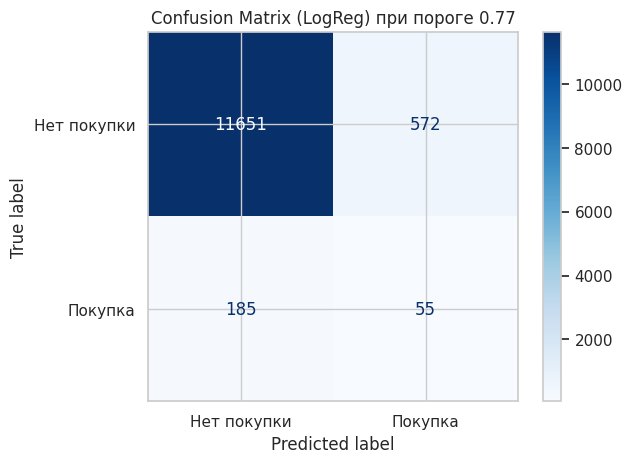

In [51]:
#  confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Нет покупки", "Покупка"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix ({best_name}) при пороге {best_thr:.2f}")
plt.show()

# Матрица ошибок (LogReg, порог = 0.77)

Модель обучена для задачи маркетинга: предсказать, совершит ли пользователь покупку в течение ближайших 90 дней.  
На графике показана матрица ошибок при применении логистической регрессии с порогом **0.77**.

Такая настройка модели **хорошо подходит для маркетинга**, потому что:

- Приоритет — **точно определить "тёплых" клиентов**, готовых к покупке.
- Порог 0.77 позволяет сократить количество **ложных срабатываний (FP)**: модель выделяет только тех, в ком достаточно уверена.
- Мы **не "переспамливаем" клиентов** и **не тратим бюджет впустую** — это важно при ограниченных ресурсах (push/email-рассылки, скидки, персональные предложения).
- Да, часть покупателей будет пропущена (Recall ≈ 23%), но **качество положительных срабатываний выше** (Precision гораздо выше, чем при пороге 0.5).

Итог:  
**Порог 0.77 — это разумный компромисс для маркетинга**, где важнее точность, чем охват.

In [52]:
#  Метрики при найденном пороге
y_hat = (y_proba >= best_thr).astype(int)
print(classification_report(y_test, y_hat, digits=4))

              precision    recall  f1-score   support

           0     0.9844    0.9532    0.9685     12223
           1     0.0877    0.2292    0.1269       240

    accuracy                         0.9393     12463
   macro avg     0.5360    0.5912    0.5477     12463
weighted avg     0.9671    0.9393    0.9523     12463



Запускаем SHAP для LogReg...


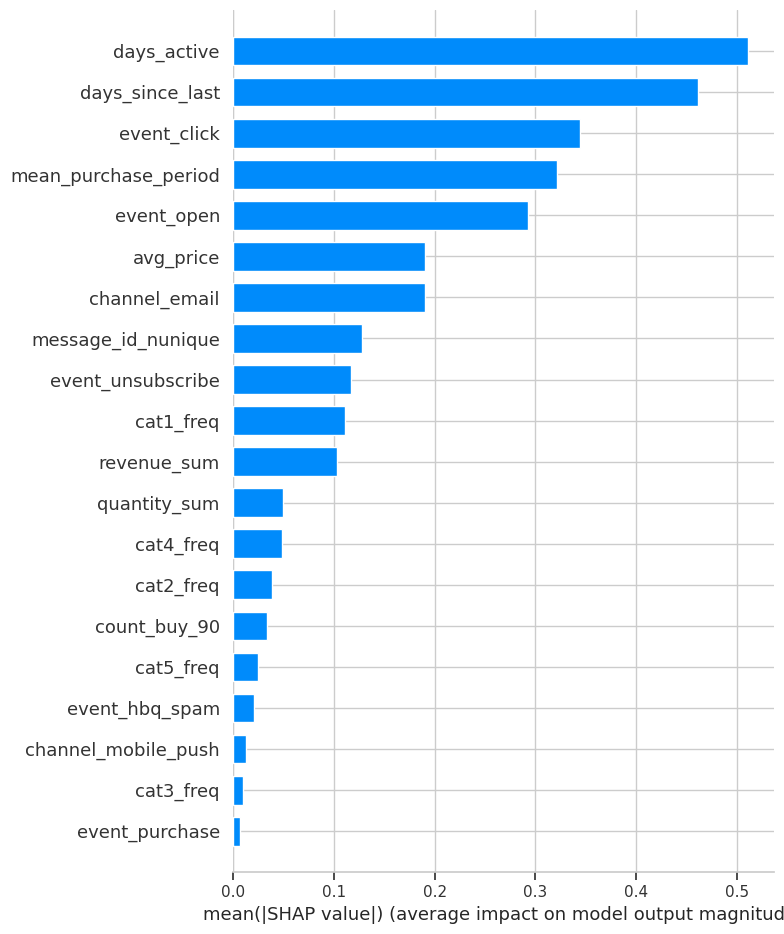

In [53]:
print(f"Запускаем SHAP для {best_name}...")

X_test_trans = best_pipe["preprocessor"].transform(X_test)

feat_names = feature_cols + [c for c in X_test.columns if c not in feature_cols]

explainer = shap.LinearExplainer(best_pipe["model"], X_test_trans)
shap_values = explainer.shap_values(X_test_trans)

# 4. Один итоговый график
shap.summary_plot(
    shap_values,
    features=X_test_trans,
    feature_names=feat_names,
    plot_type="bar",
    show=True
)

In [54]:
#  Сохранение лучшего пайплайна и порога
import joblib
joblib.dump(best_pipe, os.path.join(ARTIFACTS_DIR, f"best_pipeline_{best_name}.joblib"))
with open(os.path.join(ARTIFACTS_DIR, "best_threshold.json"), "w") as f:
    json.dump({"model": best_name, "threshold": float(best_thr)}, f, ensure_ascii=False, indent=2)

In [55]:
# Permutation Importance на лучшей модели
perm = permutation_importance(
    best_pipe, X_test, y_test,
    scoring="roc_auc",
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=N_JOBS
)

perm_df = pd.DataFrame({
    "feature": X_test.columns,
    "importance": perm.importances_mean,
    "std": perm.importances_std
}).sort_values("importance", ascending=False)

display(perm_df.head(30))
perm_df.to_csv(
    os.path.join(ARTIFACTS_DIR, f"permutation_importance_{best_name}.csv"),
    index=False
)

,feature,importance,std
4,days_active,0.159545,0.009397
5,days_since_last,0.083028,0.009430
13,event_click,0.057056,0.005842
6,avg_price,0.031477,0.005784
18,event_open,0.029748,0.006071
23,channel_email,0.017513,0.004035
1,revenue_sum,0.011019,0.003128
22,event_unsubscribe,0.010776,0.004724
7,mean_purchase_period,0.004019,0.006509
8,cat1_freq,0.003437,0.001557


In [56]:
#  Финальная сводка
print("=== Итог ===")
display(metrics_df)
print(f"Лучшая модель по ROC_AUC: {best_name}")
print(f"Рекомендованный порог по F1: {best_thr:.3f}")

=== Итог ===


,model,Accuracy,F1,Recall,Precision,ROC_AUC
0,LogReg,0.729921,0.081332,0.620833,0.043516,0.730258
4,CatBoost,0.970713,0.094293,0.079167,0.116564,0.724871
3,GBC,0.933162,0.099459,0.191667,0.067153,0.720287
5,LGBM,0.961245,0.086957,0.095833,0.079585,0.713241
6,XGB,0.733451,0.067901,0.504167,0.036402,0.687252
1,DecisionTree,0.962609,0.075397,0.079167,0.071970,0.668478
2,KNN,0.904116,0.052339,0.137500,0.032321,0.558370


Лучшая модель по ROC_AUC: LogReg
Рекомендованный порог по F1: 0.770


In [57]:
# Сохранение конфигурации проекта
project_summary = {
    "random_state": RANDOM_STATE,
    "cv_splits": CV_SPLITS,
    "models": list(base_models.keys()),
    "best_model": best_name,
    "best_threshold": float(best_thr),
    "features_count": len(feature_cols)
}
with open(os.path.join(ARTIFACTS_DIR, "project_summary.json"), "w") as f:
    json.dump(project_summary, f, ensure_ascii=False, indent=2)
print(json.dumps(project_summary, ensure_ascii=False, indent=2))

{
  "random_state": 42,
  "cv_splits": 3,
  "models": [
    "LogReg",
    "DecisionTree",
    "KNN",
    "GBC",
    "CatBoost",
    "LGBM",
    "XGB"
  ],
  "best_model": "LogReg",
  "best_threshold": 0.770329232464147,
  "features_count": 25
}


## Выводы

# Важнейшие факторы, влияющие на покупку в ближайшие 90 дней

**По SHAP (модель: LogReg) наибольший вклад дают:**

1. **`days_active`** — общий “стаж” покупателя (кол-во дней между первой и последней покупкой).  
   *Чем больше — тем выше вероятность покупки:* это признак зрелой/лояльной истории.

2. **`days_since_last`** — дней с момента последней покупки.  
   *Чем меньше — тем выше вероятность:* свежая активность — сильный сигнал возврата.

3. **`event_click`** — число (или факт) кликов по рассылкам.  
   *Положительный вклад:* клики = заинтересованность предложениями.

4. **`mean_purchase_period`** — средний интервал между покупками.  
   *Чем короче — тем выше вероятность:* регулярный цикл покупок.

5. **`event_open`** — открытия писем/пушей.  
   *Позитивный вклад:* вовлечённость в коммуникации.

6. **`avg_price`** — средняя цена покупок пользователя.  
   *Умеренно позитивный вклад:* сегмент “выше среднего чека” чаще конвертится.

7. **`channel_email`** — активность по e-mail-каналу.  
   *Положительный вклад:* канал работает как драйвер конверсии.

8. **`message_id_nunique`** — разнообразие сообщений, полученных клиентом.  
   *Положительный вклад:* регулярные касания поддерживают конверсию.

9. **`event_unsubscribe`** — отписки.  
   *Негативный вклад:* сигнал “охлаждения” — снижает вероятность покупки.

10. **`cat1_freq`** (и другие `cat*_freq`) — частотность предпочтительных категорий.  
    *Позитивный вклад:* выраженные товарные предпочтения помогают “попасть” оффером.

11. **`revenue_sum`, `quantity_sum`** — накопленная выручка/кол-во покупок.  
    *Положительный вклад:* исторически “ценные” клиенты чаще возвращаются.

12. **`event_hbq_spam` / `channel_mobile_push` / `cat3_freq`**  
    *Слабый/ситуативный вклад:* второстепенные для итогового прогноза.

---

## Выводы для бизнеса

- **Поведенческие темпы критичны:** свежесть активности (`days_since_last`) и регулярность (`mean_purchase_period`) — главные индикаторы возврата.
- **Коммуникации работают:** клики/открытия напрямую поднимают вероятность покупки — корректная частота и релевантность рассылок повышают конверсию.
- **Персонализация по категориям:** явные товарные предпочтения (`cat*_freq`) усиливают отклик — офферы стоит персонализировать по топ-категориям клиента.
- **Сигналы риска:** отписки и спам-инциденты снижают шанс покупки — таких клиентов лучше исключать из агрессивных кампаний, переключаясь на “ре-энгейджмент”.

---

## Как использовать модель

- **Что предсказываем:** вероятность, что клиент совершит **покупку в течение 90 дней**.  
- **Рекомендация по порогу:** подбираем порог по F1 или по бизнес-целевой метрике (ROI/доход на отправку).  
- **Операционализация:**  
  - топ-N клиентов по вероятности → в приоритетную кампанию;  
  - персонализируем оффер под их топ-категории;  
  - усиливаем касания по email (и push для вовлечённых), но исключаем клиентов с отписками/спам-флагами.
